In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from traffic import TrafficEnv
from agent import PageHinkleyTest, AdaptativeAgent

# Parámetros del entorno
LAMBDA_ARRIVAL_C1 = 4       # Parámetro de la distribución de Poisson para llegadas
LAMBDA_ARRIVAL_C2 = 2       # Parámetro de la distribución de Poisson para llegadas
MAX_STATE = 10               # Número máximo de coches en el sistema

# Parámetros de Q-Learning
ALPHA = 0.1              # Tasa de aprendizaje
GAMMA = 0.9             # Factor de descuento
EPSILON = 1.0            # Tasa de exploración inicial
EPSILON_MIN = 0.01
EPSILON_DECAY = 0.999
NUM_EPISODES = 10001
MAX_STEPS = 30

## Random approach (baseline)

In [2]:
env = TrafficEnv(c1_lambda=LAMBDA_ARRIVAL_C1, 
                c2_lambda=LAMBDA_ARRIVAL_C2, 
                max_steps=MAX_STEPS, 
                max_state=MAX_STATE)

rewards_per_episode = []
epsilon = EPSILON

for episode in range(NUM_EPISODES):
    state = tuple(env.reset())   # (c1, c2)
    total_reward = 0.0

    for step in range(MAX_STEPS):
        action = random.randint(0, len(env.actions)-1) 
        next_state, reward, done, info = env.step(action)
        c1, c2          = state
        next_c1, next_c2 = next_state

        state = tuple(next_state)
        total_reward += reward

        if done:
            break

    # Decaimiento de epsilon
    epsilon = max(EPSILON_MIN, epsilon * EPSILON_DECAY)

    rewards_per_episode.append(total_reward)
    if episode % 500 == 0:
        avg = np.mean(rewards_per_episode[-500:])
        print(f"Episode {episode:5d} — AvgReward (últ.500) = {avg:.3f}  ε={epsilon:.3f}")

# Estadísticas finales
print("Reward medio:", np.mean(rewards_per_episode))
print("Reward máximo:", np.max(rewards_per_episode))
print("Reward mínimo:", np.min(rewards_per_episode))

Episode     0 — AvgReward (últ.500) = -636.000  ε=0.999
Episode   500 — AvgReward (últ.500) = -553.402  ε=0.606
Episode  1000 — AvgReward (últ.500) = -556.210  ε=0.367
Episode  1500 — AvgReward (últ.500) = -551.454  ε=0.223
Episode  2000 — AvgReward (últ.500) = -544.184  ε=0.135
Episode  2500 — AvgReward (últ.500) = -546.320  ε=0.082
Episode  3000 — AvgReward (últ.500) = -544.510  ε=0.050
Episode  3500 — AvgReward (últ.500) = -551.456  ε=0.030
Episode  4000 — AvgReward (últ.500) = -544.210  ε=0.018
Episode  4500 — AvgReward (últ.500) = -545.578  ε=0.011
Episode  5000 — AvgReward (últ.500) = -555.096  ε=0.010
Episode  5500 — AvgReward (últ.500) = -549.242  ε=0.010
Episode  6000 — AvgReward (últ.500) = -540.368  ε=0.010
Episode  6500 — AvgReward (últ.500) = -546.964  ε=0.010
Episode  7000 — AvgReward (últ.500) = -542.790  ε=0.010
Episode  7500 — AvgReward (últ.500) = -547.534  ε=0.010
Episode  8000 — AvgReward (últ.500) = -551.182  ε=0.010
Episode  8500 — AvgReward (últ.500) = -546.886  

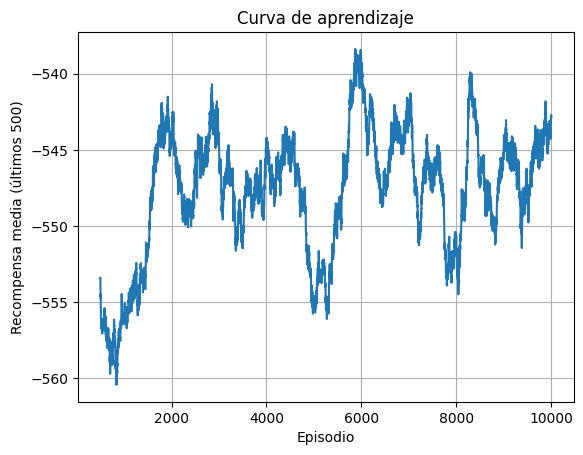

In [3]:
#plot moving average of rewards
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

ma = moving_average(rewards_per_episode, 500)
episodios = np.arange(len(ma)) + 500
plt.plot(episodios, ma)
plt.xlabel('Episodio')
plt.ylabel('Recompensa media (últimos 500)')
plt.title('Curva de aprendizaje')
plt.grid(True)
plt.show()

## Traditional Q-learning approach (baseline)

In [4]:
# Inicialización de la tabla Q|
q_table = np.zeros((MAX_STATE+1, MAX_STATE+1, len(env.actions)))

def choose_action(state, q_table, epsilon=0):
    c1, c2 = state
    if random.random() < epsilon:
        return random.randrange(len(env.actions))
    else:
        return int(np.argmax(q_table[c1, c2, :]))

env = TrafficEnv(c1_lambda=LAMBDA_ARRIVAL_C1, 
                c2_lambda=LAMBDA_ARRIVAL_C2, 
                max_steps=MAX_STEPS, 
                max_state=MAX_STATE)

rewards_per_episode = []
episode_changes = [3000]
epsilon = EPSILON

for episode in range(NUM_EPISODES):
    state = tuple(env.reset())   # (c1, c2)
    total_reward = 0.0

    for step in range(MAX_STEPS):
        action = choose_action(state, q_table, epsilon)
        next_state, reward, done, info = env.step(action)
        c1, c2          = state
        next_c1, next_c2 = next_state

        # Bellman update
        best_next = np.max(q_table[next_c1, next_c2, :])
        td_target = reward + GAMMA * best_next
        td_error  = td_target - q_table[c1, c2, action]
        q_table[c1, c2, action] += ALPHA * td_error

        state = tuple(next_state)
        total_reward += reward

        if done:
            break

    # Decaimiento de epsilon
    epsilon = max(EPSILON_MIN, epsilon * EPSILON_DECAY)

    rewards_per_episode.append(total_reward)
    
    if episode in episode_changes:
        if episode == episode_changes[0]:
            env.c1_lambda = 4
            env.c2_lambda = 6
    
    if episode % 500 == 0:
        avg = np.mean(rewards_per_episode[-500:])
        print(f"Episode {episode:5d} — AvgReward (últ.500) = {avg:.3f}  ε={epsilon:.3f}")

# Estadísticas finales
print("Reward medio:", np.mean(rewards_per_episode))
print("Reward máximo:", np.max(rewards_per_episode))
print("Reward mínimo:", np.min(rewards_per_episode))

Episode     0 — AvgReward (últ.500) = -596.000  ε=0.999
Episode   500 — AvgReward (últ.500) = -483.142  ε=0.606
Episode  1000 — AvgReward (últ.500) = -404.746  ε=0.367
Episode  1500 — AvgReward (últ.500) = -366.282  ε=0.223
Episode  2000 — AvgReward (últ.500) = -340.988  ε=0.135
Episode  2500 — AvgReward (últ.500) = -328.500  ε=0.082
Episode  3000 — AvgReward (últ.500) = -318.924  ε=0.050
Episode  3500 — AvgReward (últ.500) = -578.366  ε=0.030
Episode  4000 — AvgReward (últ.500) = -557.480  ε=0.018
Episode  4500 — AvgReward (últ.500) = -531.688  ε=0.011
Episode  5000 — AvgReward (últ.500) = -531.974  ε=0.010
Episode  5500 — AvgReward (últ.500) = -525.538  ε=0.010
Episode  6000 — AvgReward (últ.500) = -522.302  ε=0.010
Episode  6500 — AvgReward (últ.500) = -507.420  ε=0.010
Episode  7000 — AvgReward (últ.500) = -517.134  ε=0.010
Episode  7500 — AvgReward (últ.500) = -507.652  ε=0.010
Episode  8000 — AvgReward (últ.500) = -503.848  ε=0.010
Episode  8500 — AvgReward (últ.500) = -503.214  

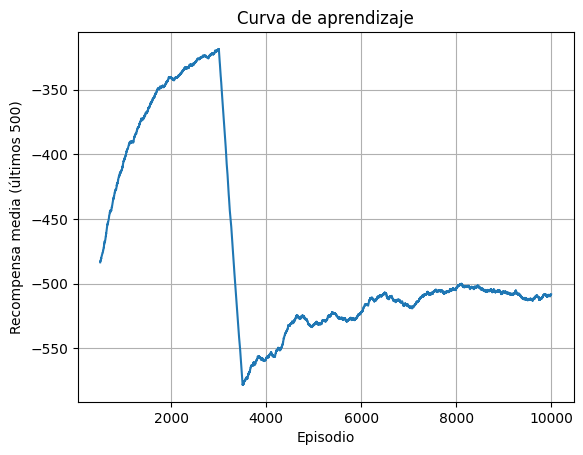

In [5]:
ma = moving_average(rewards_per_episode, 500)
episodios = np.arange(len(ma)) + 500
plt.plot(episodios, ma)
plt.xlabel('Episodio')
plt.ylabel('Recompensa media (últimos 500)')
plt.title('Curva de aprendizaje')
plt.grid(True)
plt.show()

{'served_c1': 3, 'arr1_during': 5, 'served_c2': 3, 'arr2_during': 5, 'penalty': 0}


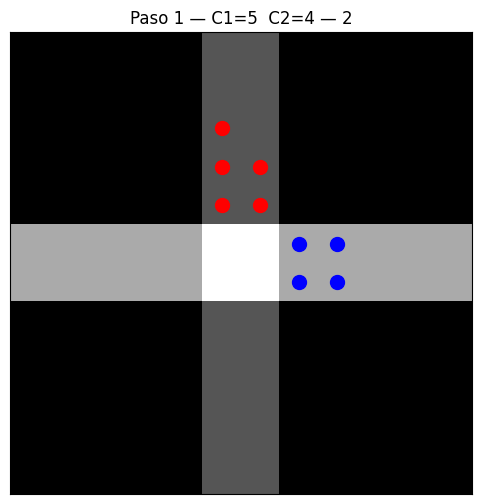

{'served_c1': 2, 'arr1_during': 2, 'served_c2': 5, 'arr2_during': 6, 'penalty': 0}


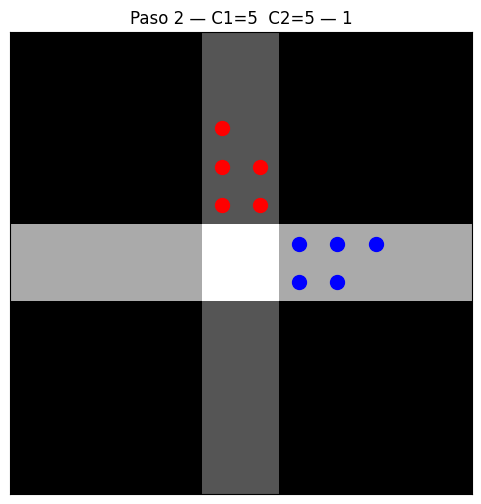

{'served_c1': 5, 'arr1_during': 2, 'served_c2': 2, 'arr2_during': 7, 'penalty': 0}


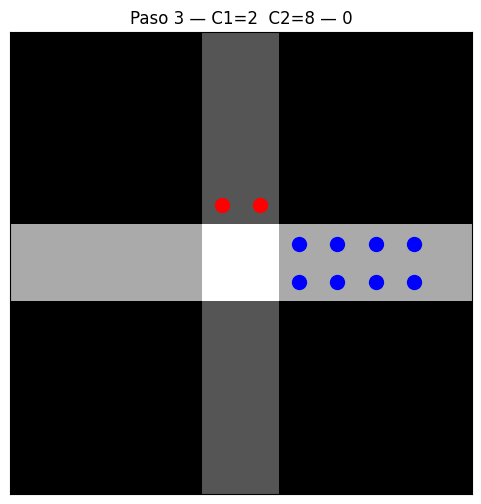

{'served_c1': 2, 'arr1_during': 1, 'served_c2': 5, 'arr2_during': 7, 'penalty': 0}


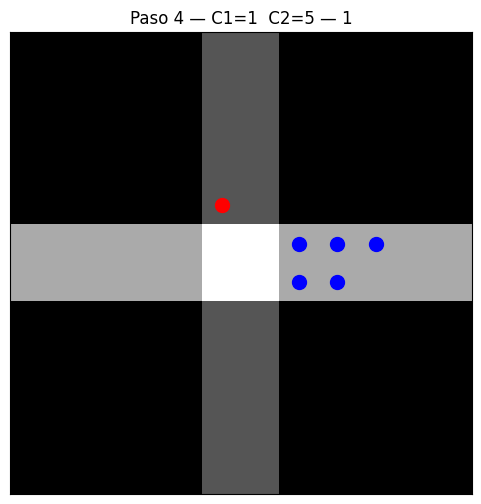

{'served_c1': 1, 'arr1_during': 5, 'served_c2': 5, 'arr2_during': 6, 'penalty': 3}


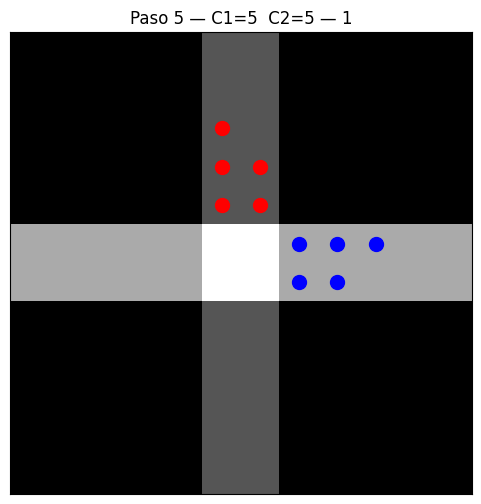

{'served_c1': 5, 'arr1_during': 3, 'served_c2': 2, 'arr2_during': 7, 'penalty': 0}


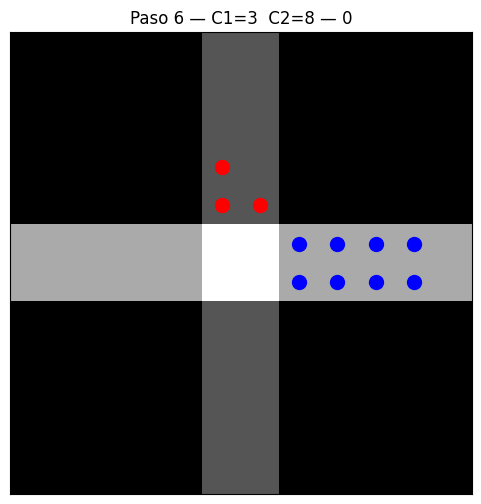

{'served_c1': 3, 'arr1_during': 3, 'served_c2': 3, 'arr2_during': 6, 'penalty': 0}


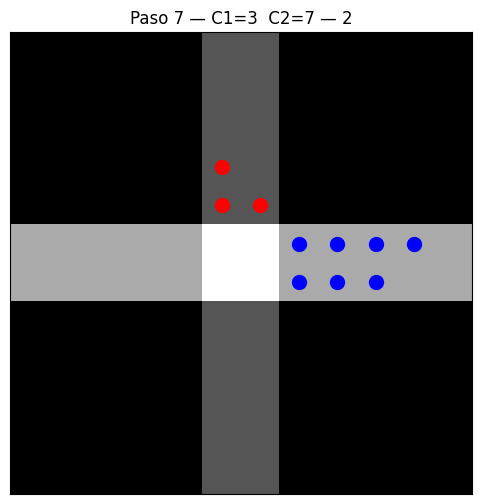

{'served_c1': 2, 'arr1_during': 2, 'served_c2': 5, 'arr2_during': 4, 'penalty': 0}


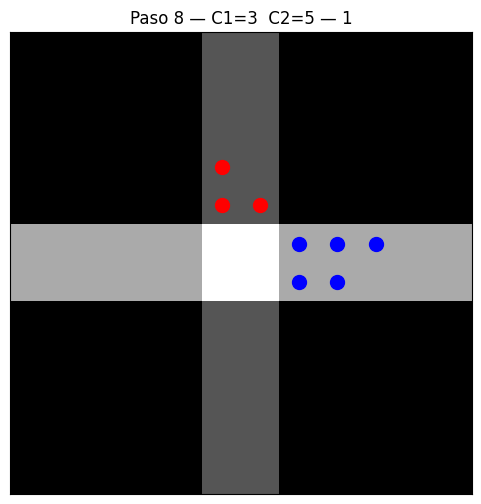

{'served_c1': 3, 'arr1_during': 5, 'served_c2': 3, 'arr2_during': 8, 'penalty': 0}


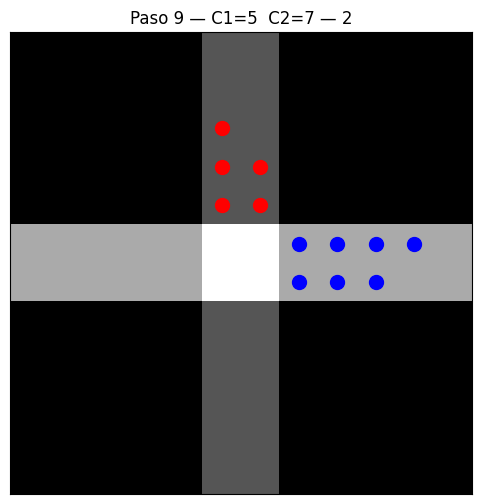

{'served_c1': 5, 'arr1_during': 9, 'served_c2': 2, 'arr2_during': 3, 'penalty': 0}


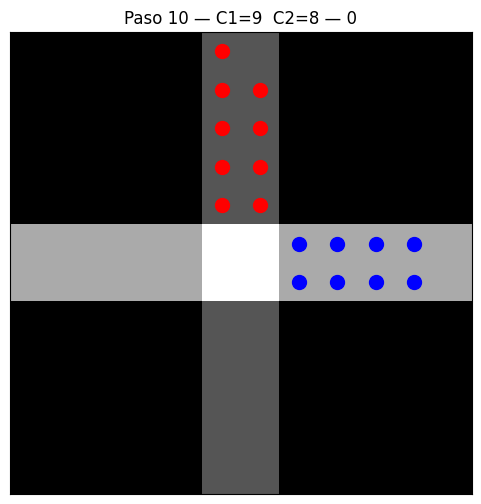

{'served_c1': 5, 'arr1_during': 8, 'served_c2': 2, 'arr2_during': 2, 'penalty': 0}


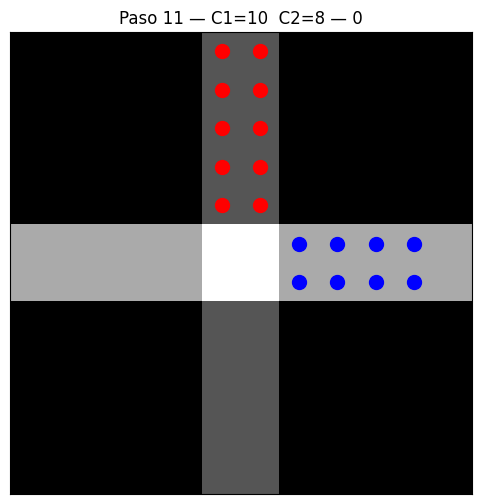

{'served_c1': 5, 'arr1_during': 6, 'served_c2': 2, 'arr2_during': 6, 'penalty': 0}


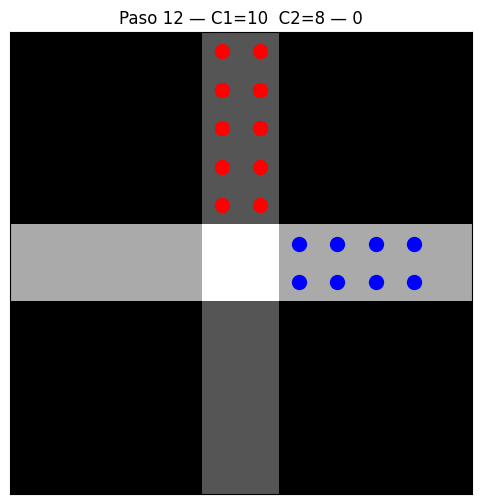

{'served_c1': 5, 'arr1_during': 5, 'served_c2': 2, 'arr2_during': 8, 'penalty': 0}


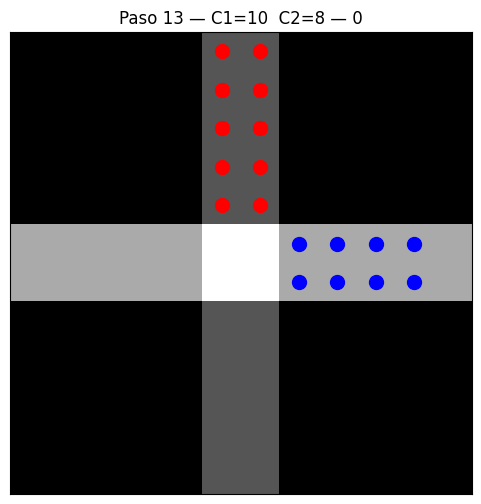

{'served_c1': 5, 'arr1_during': 5, 'served_c2': 2, 'arr2_during': 5, 'penalty': 0}


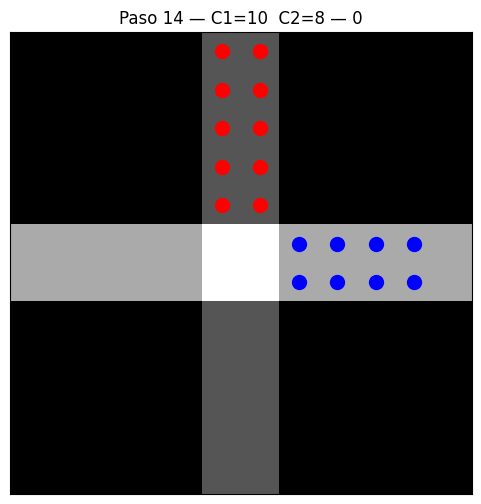

{'served_c1': 5, 'arr1_during': 3, 'served_c2': 2, 'arr2_during': 1, 'penalty': 0}


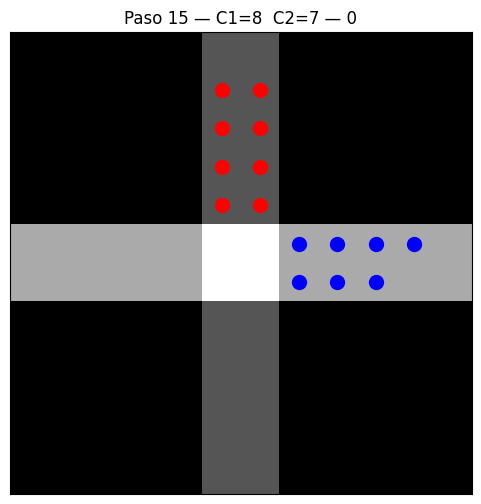

{'served_c1': 5, 'arr1_during': 5, 'served_c2': 2, 'arr2_during': 4, 'penalty': 0}


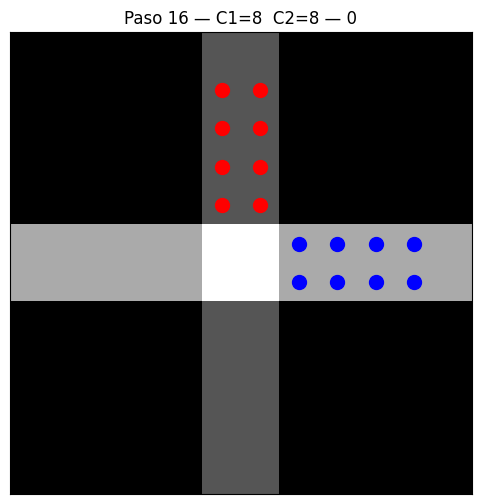

{'served_c1': 5, 'arr1_during': 6, 'served_c2': 2, 'arr2_during': 5, 'penalty': 0}


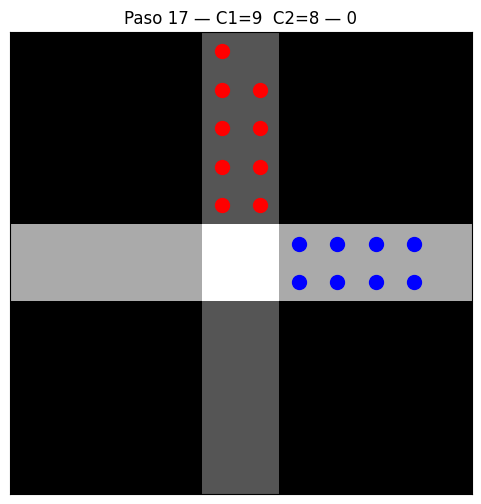

{'served_c1': 5, 'arr1_during': 6, 'served_c2': 2, 'arr2_during': 8, 'penalty': 0}


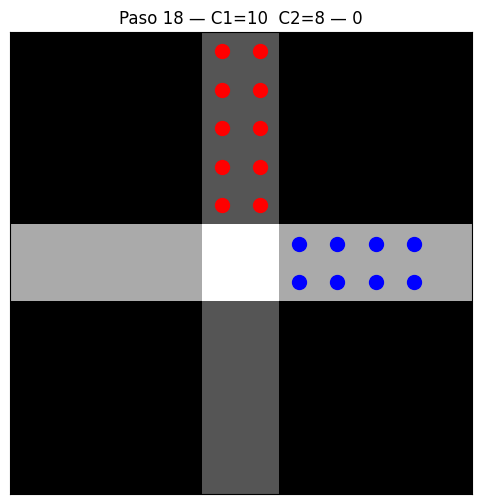

{'served_c1': 5, 'arr1_during': 4, 'served_c2': 2, 'arr2_during': 4, 'penalty': 0}


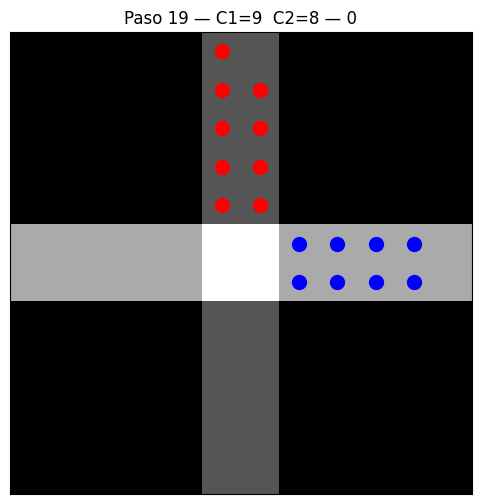

{'served_c1': 5, 'arr1_during': 3, 'served_c2': 2, 'arr2_during': 5, 'penalty': 0}


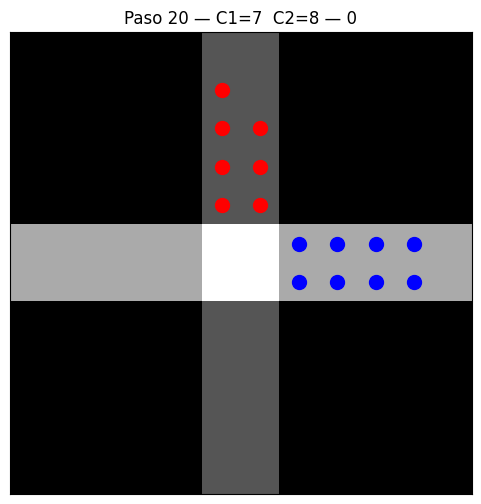

In [6]:
state = env.reset()
for _ in range(20):
    action = choose_action(state, q_table=q_table, epsilon=0)
    state, reward, done, info = env.step(action)
    print(info)
    env.render(title=f" — {action}")

## Adaptive Agent

In [7]:
# Inicialización del entorno y parámetros
N_ROWS = MAX_STATE + 1
N_COLS = MAX_STATE + 1

EXPLOTATION = 0.2

# Inicialización del agente
agent = AdaptativeAgent(
    initial_state=(4, 4),
    actions=[0,1,2],
    n_rows=N_ROWS,
    n_cols=N_COLS,
    decay_rate=.001, # más grande => más errático
    alpha=ALPHA,
    alpha_max=0.15,
    td_threshold=20, # más pequeño => más sensible
    min_epsilon=EPSILON_MIN,
)


# Inicialización del Page-Hinkley Test
ph_test = PageHinkleyTest(threshold=10000)

# Variables para el seguimiento del entrenamiento
learning_curve = []
exploration_curve = []

change_detection = []

env = TrafficEnv(c1_lambda=LAMBDA_ARRIVAL_C1, 
                c2_lambda=LAMBDA_ARRIVAL_C2, 
                max_steps=MAX_STEPS, 
                max_state=MAX_STATE)
rewards_per_episode = []

episode_changes = [3000]


eps = 1
# Bucle de entrenamiento
for ep in range(NUM_EPISODES):
    state = tuple(env.reset())      # (c1, c2)
    agent.current_state = state
    total_reward = 0.0
    
    for step in range(MAX_STEPS):
        # 1) Elegir acción ε-greedy
        action = agent.choose_action(eps)

        # 2) Interactuar con el entorno
        next_state, reward, done, info = env.step(action)
        next_state = tuple(next_state)

        # 3) Guardar recompensa
        total_reward += reward

        # 4) Actualizar Q-value con tasa adaptativa
        agent.update_q_value(
            current_state=state,
            action=action,
            reward=reward,
            next_state=next_state
        )

        state = next_state
        agent.current_state = next_state

        if done:
            break
        
                
    # Decay de ε **por episodio**:
    eps = max(EPSILON_MIN, eps * EPSILON_DECAY)
    
    if ph_test.update(total_reward):
        print(f"Cambio detectado en episodio {ep} con recompensa {total_reward}", eps)
        change_detection.append(ep)
        
        eps = 1 # Aumentar exploración
        # Definir nuevas acciones ---
        extra_actions = [
            {'C1_service': 7, 'C2_service':  3},  # muy prioritario a C1
            {'C1_service':  3, 'C2_service': 7},  # muy prioritario a C2
        ]

        # Concatenar al conjunto actual ---
        updated_actions = env.actions + extra_actions
        env.actions   = updated_actions
        agent.update_actions(updated_actions)
        
        ph_test.reset()
        
    rewards_per_episode.append(total_reward)
    
    if ep in episode_changes:
        if ep == episode_changes[0]:
            env.c1_lambda = 4
            env.c2_lambda = 6
        
            
    if ep % 500 == 0:
        avg_last = np.mean(rewards_per_episode[-500:])
        print(f"Episodio {ep:5d} — Reward medio últimos 500 = {avg_last:.3f} — ε={eps:.3f} - α={agent.effective_alpha:.3f}")
    
            
print("Reward medio global:", np.mean(rewards_per_episode))
print("Reward máximo:",       np.max(rewards_per_episode))
print("Reward mínimo:",       np.min(rewards_per_episode))

Episodio     0 — Reward medio últimos 500 = -682.000 — ε=0.999 - α=0.142
Episodio   500 — Reward medio últimos 500 = -483.670 — ε=0.606 - α=0.115
Episodio  1000 — Reward medio últimos 500 = -412.374 — ε=0.367 - α=0.100
Episodio  1500 — Reward medio últimos 500 = -367.566 — ε=0.223 - α=0.100
Episodio  2000 — Reward medio últimos 500 = -339.378 — ε=0.135 - α=0.100
Episodio  2500 — Reward medio últimos 500 = -332.508 — ε=0.082 - α=0.100
Episodio  3000 — Reward medio últimos 500 = -313.616 — ε=0.050 - α=0.100
Cambio detectado en episodio 3046 con recompensa -626.0 0.04742885328279781
Episodio  3500 — Reward medio últimos 500 = -499.952 — ε=0.635 - α=0.100
Episodio  4000 — Reward medio últimos 500 = -434.504 — ε=0.385 - α=0.100
Episodio  4500 — Reward medio últimos 500 = -399.152 — ε=0.233 - α=0.100
Episodio  5000 — Reward medio últimos 500 = -361.374 — ε=0.142 - α=0.100
Episodio  5500 — Reward medio últimos 500 = -348.386 — ε=0.086 - α=0.100
Episodio  6000 — Reward medio últimos 500 = -344

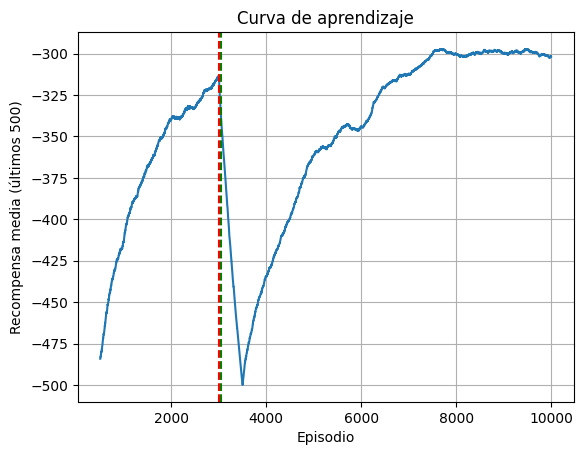

In [8]:
ma = moving_average(rewards_per_episode, 500)
episodios = np.arange(len(ma)) + 500
plt.plot(episodios, ma)
for v in episode_changes:
    plt.axvline(x=v, color='r', linestyle='--')
for c in change_detection:
    plt.axvline(x=c, color='g', linestyle='--')
plt.xlabel('Episodio')
plt.ylabel('Recompensa media (últimos 500)')
plt.title('Curva de aprendizaje')
plt.grid(True)

plt.show()

{'served_c1': 2, 'arr1_during': 9, 'served_c2': 5, 'arr2_during': 5, 'penalty': 0}


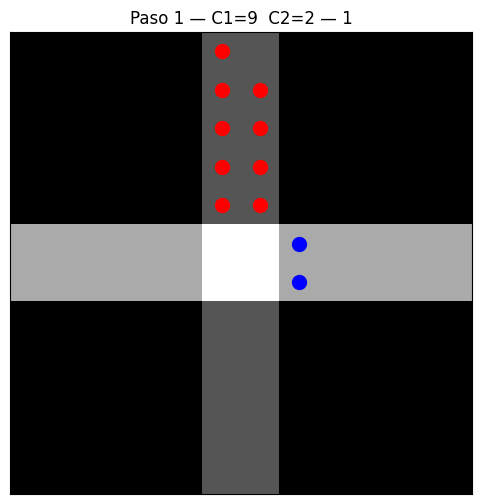

{'served_c1': 7, 'arr1_during': 2, 'served_c2': 3, 'arr2_during': 5, 'penalty': 0}


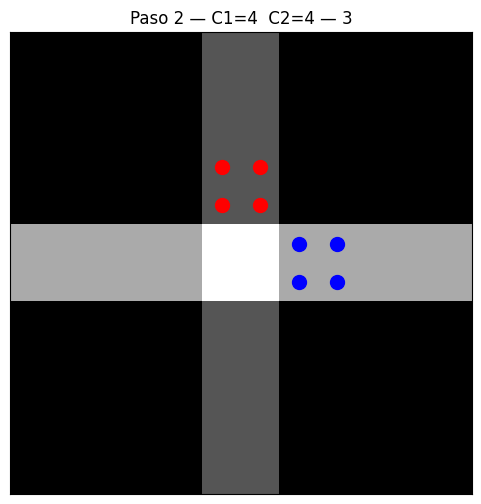

{'served_c1': 3, 'arr1_during': 3, 'served_c2': 7, 'arr2_during': 8, 'penalty': 0}


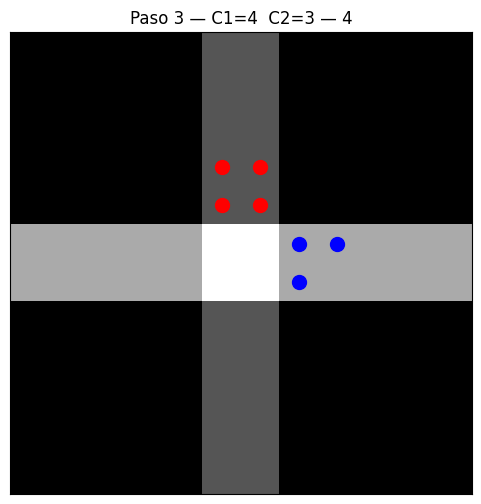

{'served_c1': 3, 'arr1_during': 3, 'served_c2': 7, 'arr2_during': 5, 'penalty': 0}


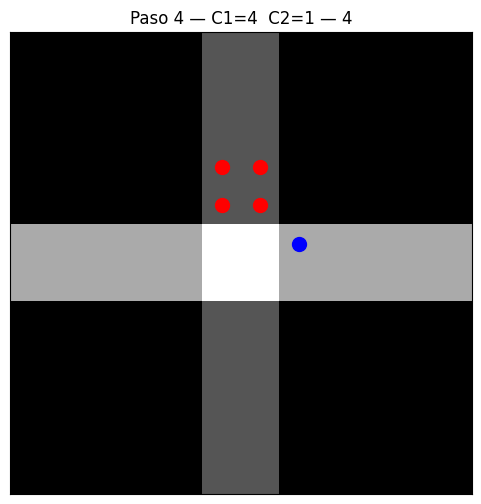

{'served_c1': 4, 'arr1_during': 3, 'served_c2': 2, 'arr2_during': 11, 'penalty': 3}


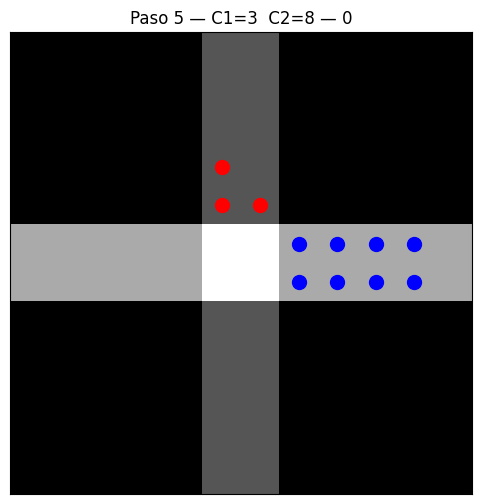

{'served_c1': 3, 'arr1_during': 3, 'served_c2': 7, 'arr2_during': 5, 'penalty': 0}


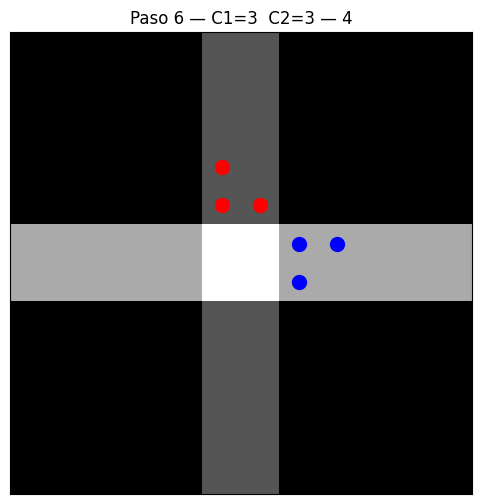

{'served_c1': 3, 'arr1_during': 6, 'served_c2': 7, 'arr2_during': 8, 'penalty': 0}


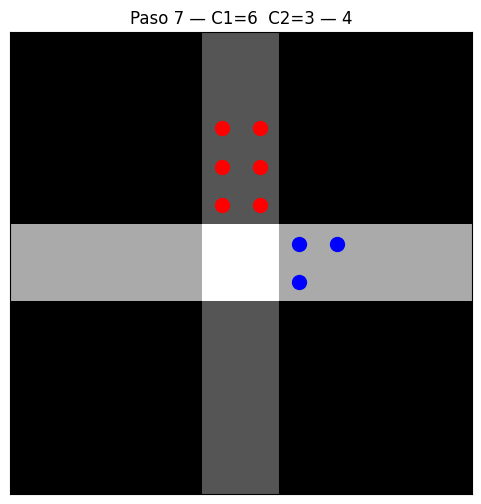

{'served_c1': 3, 'arr1_during': 5, 'served_c2': 7, 'arr2_during': 6, 'penalty': 0}


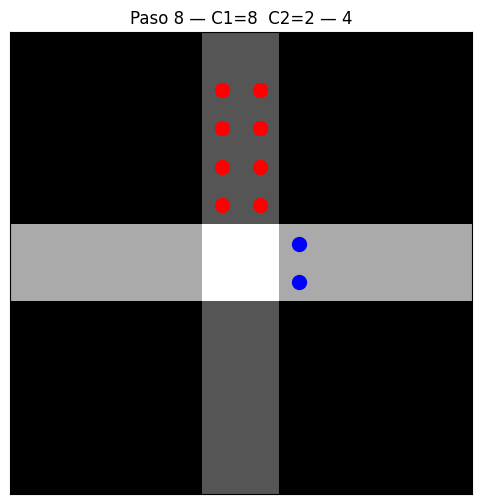

{'served_c1': 7, 'arr1_during': 5, 'served_c2': 3, 'arr2_during': 7, 'penalty': 0}


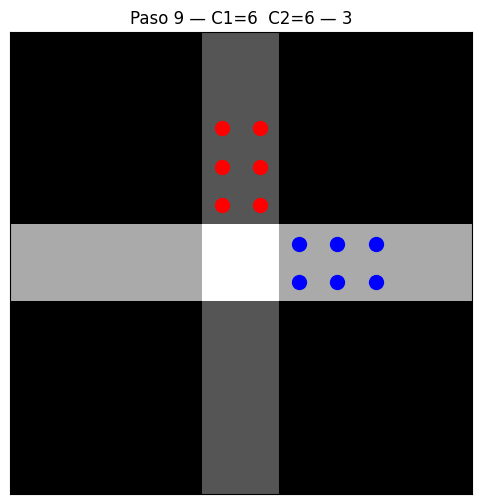

{'served_c1': 6, 'arr1_during': 5, 'served_c2': 3, 'arr2_during': 5, 'penalty': 3}


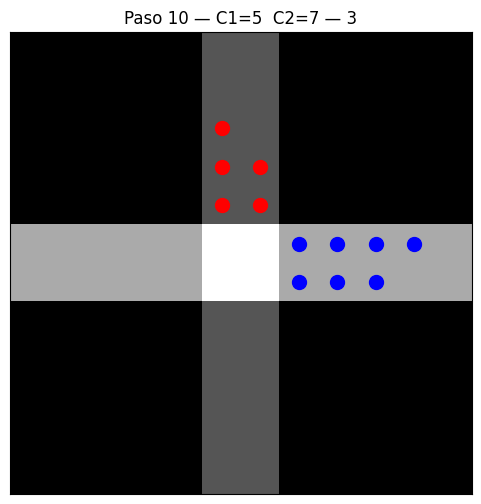

{'served_c1': 3, 'arr1_during': 2, 'served_c2': 7, 'arr2_during': 2, 'penalty': 0}


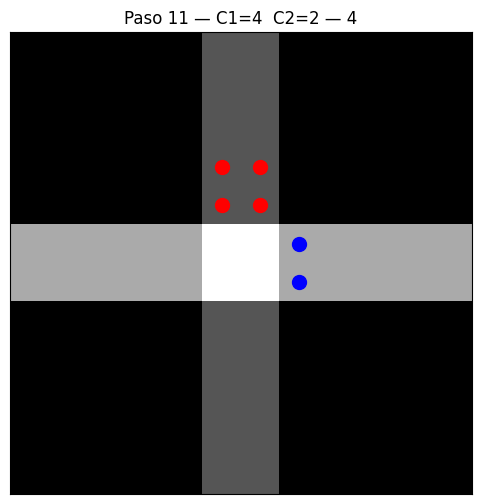

{'served_c1': 3, 'arr1_during': 1, 'served_c2': 4, 'arr2_during': 2, 'penalty': 9}


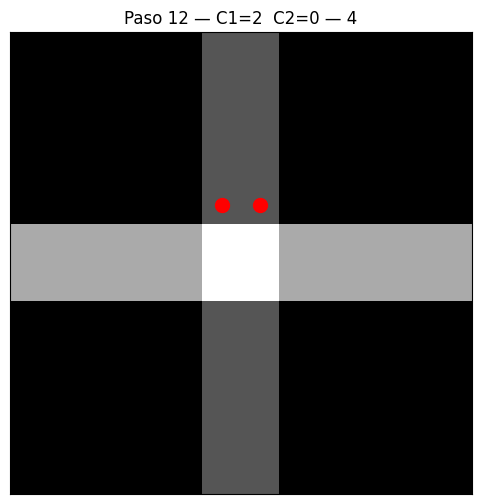

{'served_c1': 2, 'arr1_during': 6, 'served_c2': 5, 'arr2_during': 7, 'penalty': 0}


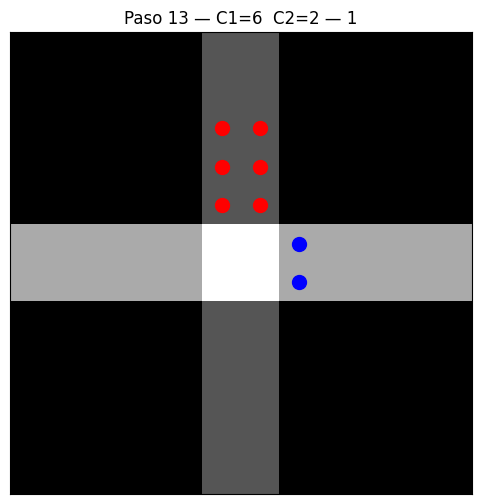

{'served_c1': 6, 'arr1_during': 3, 'served_c2': 3, 'arr2_during': 8, 'penalty': 3}


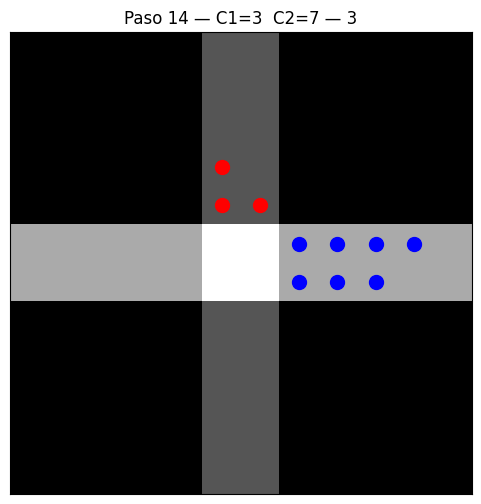

{'served_c1': 3, 'arr1_during': 3, 'served_c2': 7, 'arr2_during': 3, 'penalty': 0}


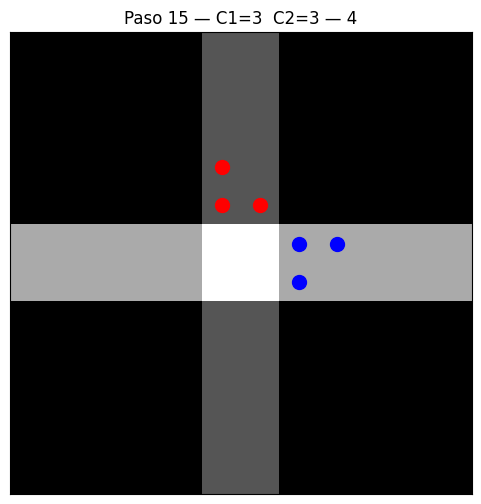

{'served_c1': 3, 'arr1_during': 5, 'served_c2': 7, 'arr2_during': 4, 'penalty': 0}


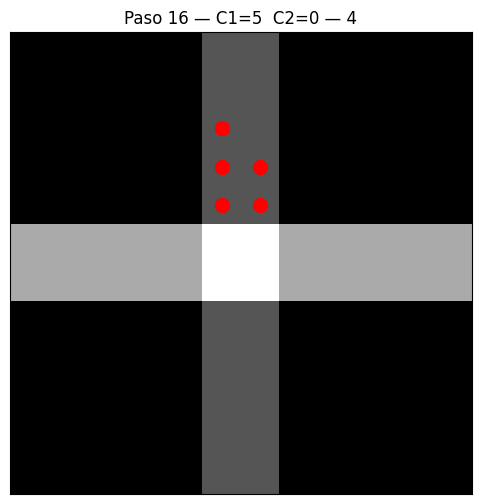

{'served_c1': 5, 'arr1_during': 2, 'served_c2': 2, 'arr2_during': 9, 'penalty': 0}


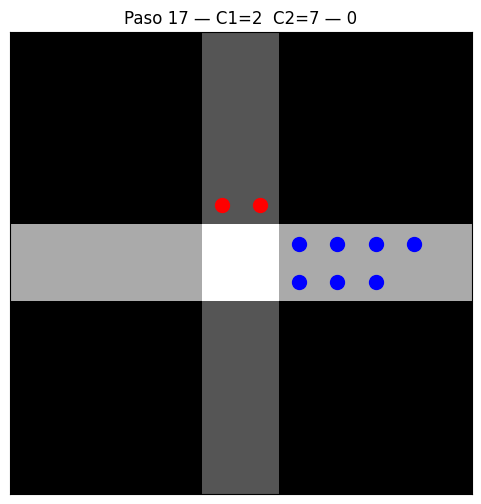

{'served_c1': 2, 'arr1_during': 2, 'served_c2': 5, 'arr2_during': 4, 'penalty': 0}


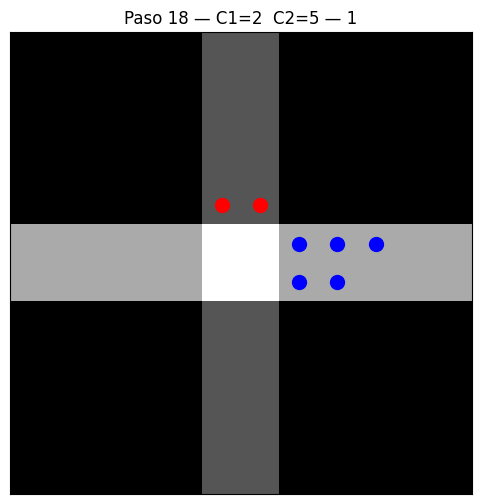

{'served_c1': 2, 'arr1_during': 3, 'served_c2': 7, 'arr2_during': 3, 'penalty': 3}


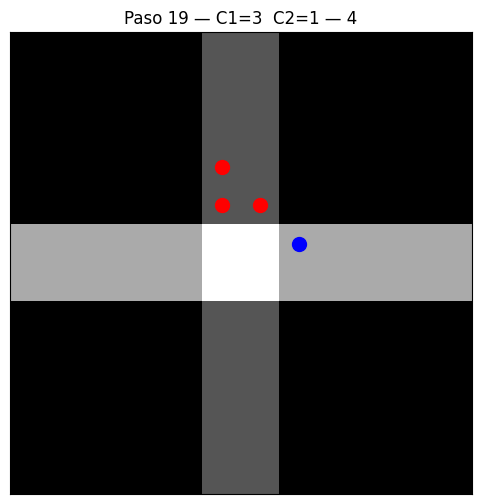

{'served_c1': 3, 'arr1_during': 5, 'served_c2': 3, 'arr2_during': 5, 'penalty': 0}


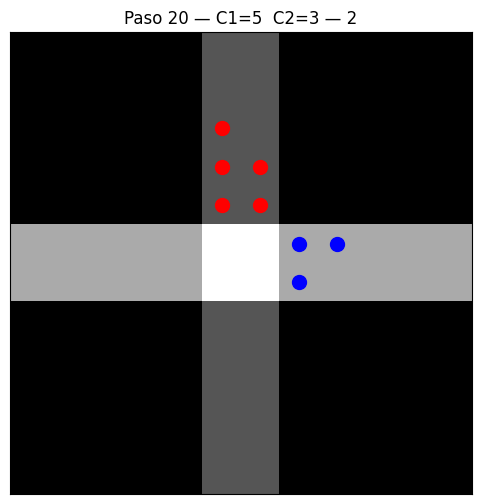

In [9]:
# simulate agent:
state = env.reset()
for _ in range(20):
    action = agent.get_best_action(state)[0]
    state, reward, done, info = env.step(action)
    print(info)
    env.render(title=f" — {agent.map_ix_action[action]}")

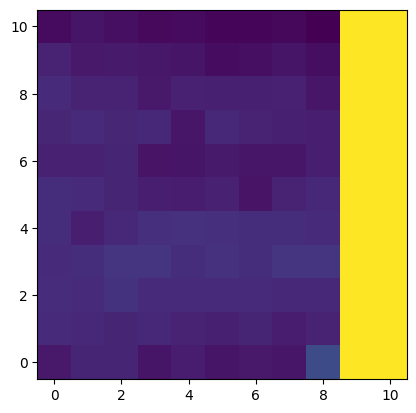

In [10]:
plt.imshow(np.max(agent.q_knowledge, axis=0), origin='lower')

In [11]:
np.max(agent.q_knowledge, axis=0)

array([[-106.57786081, -102.34013036, -102.28587172, -107.88497887,
        -104.97746573, -107.56937603, -106.51141192, -107.1439609 ,
         -87.52164115,    0.        ,    0.        ],
       [-100.07887011, -101.04937228, -102.39755452, -100.87011348,
        -103.2857536 , -104.06864773, -102.62511993, -105.72379518,
        -103.36046806,    0.        ,    0.        ],
       [ -99.52821208, -100.14058876,  -97.46639999, -100.0576945 ,
         -99.96679175, -100.02678262, -100.72809695, -101.55963172,
        -101.67173915,    0.        ,    0.        ],
       [-100.57888153,  -99.3468661 ,  -96.77881249,  -97.27416893,
         -99.29942965,  -98.12232547,  -99.17390554,  -97.23933272,
         -96.57651387,    0.        ,    0.        ],
       [ -99.07820532, -104.64481694, -101.72144081,  -98.77436034,
         -97.90252966,  -98.71290218,  -99.51759694,  -99.07518534,
        -100.09523963,    0.        ,    0.        ],
       [ -99.37821304, -100.74095857, -102.2834333